In [2]:
%load_ext autoreload
%autoreload 2
from notebook_utils import *

import warnings
warnings.filterwarnings('ignore')

# PLOTTING
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":3.0,
    "savefig.dpi":500,
    'text.latex.preamble':r'\boldmath'
})
plt.rc('axes', grid=True)
cmap=plt.cm.Spectral_r
savedir= '/private/home/sdascoli/recur/figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

# Runs

In [63]:
runs = []
logs = []

paths = [
    #'/checkpoint/pakamienny/recur/paper/base',
    #'/checkpoint/fcharton/recur/final/large',
    #'/checkpoint/sdascoli/recur/final/random',
    #'/checkpoint/sdascoli/recur/paper/large',
    '/checkpoint/sdascoli/recur/paper/all'
       ]
#base = '/checkpoint/pakamienny/recur/final/base'
#base = '/checkpoint/fcharton/recur/final/large'
#base = '/checkpoint/sdascoli/recur/final/large'

NaN = np.nan
Infinity = np.nan

for path in paths:

    path = path.rstrip('/') + '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        if dirname.endswith('src'): continue
        if len(dirnames)<1000: print(dirname)
        try : 
            run = {}
            args = pickle.load(open(dirname+'/params.pkl', 'rb'))
            run['args'] = args
            if 'use_sympy' not in args:
                setattr(args,'use_sympy',False)
            if 'mantissa_len' not in args:
                setattr(args,'mantissa_len',1)
            if 'train_noise' not in args:
                setattr(args,'train_noise', 0)
            setattr(args, 'extra_constants', '')
            run['logs'] = []
            run['num_params'] = []
            #logfile = glob.glob(dirname+'/*.err')[-1]
            logfile = dirname+'/train.log'
            f = open(logfile, "r")
            for line in f.readlines():
                if '__log__' in line:
                    log = eval(line[line.find('{'):].rstrip('\n'))
                    if not run['logs']: run['logs'].append(log)
                    else: 
                        if log['valid1_recurrence_beam_acc'] != run['logs'][-1]['valid1_recurrence_beam_acc']: run['logs'].append(log)
            f.close()
            args.output_dir = Path(dirname)
            runs.append(run)
        except Exception as e: 
            print(e)
            print('failed !'.format(dirname))
            fails += 1
    print('{} fails'.format(fails))
    
latest = min([len(run['logs']) for run in runs])-1
print('latest : ',latest)
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    try: params[k] = sorted(list(set(params[k])))
    except: pass

/checkpoint/sdascoli/recur/paper/all/
6 runs found
/checkpoint/sdascoli/recur/paper/all/float_sequences_True_output_numeric_True_batch_size_32_use_sympy_False
/checkpoint/sdascoli/recur/paper/all/float_sequences_True_output_numeric_False_batch_size_32_use_sympy_False
/checkpoint/sdascoli/recur/paper/all/float_sequences_False_output_numeric_True_batch_size_32_use_sympy_False
/checkpoint/sdascoli/recur/paper/all/float_sequences_False_output_numeric_False_batch_size_32_use_sympy_False
/checkpoint/sdascoli/recur/paper/all/float_sequences_True_output_numeric_False_batch_size_32_prob_rand_0.1
/checkpoint/sdascoli/recur/paper/all/float_sequences_True_output_numeric_False_batch_size_32_prob_rand_0.3
0 fails
latest :  10


# Performance

/checkpoint/sdascoli/recur/paper/all/float_sequences_True_output_numeric_True_batch_size_32_use_sympy_False [] 100 29.07
/checkpoint/sdascoli/recur/paper/all/float_sequences_True_output_numeric_False_batch_size_32_use_sympy_False [] 100 44.47


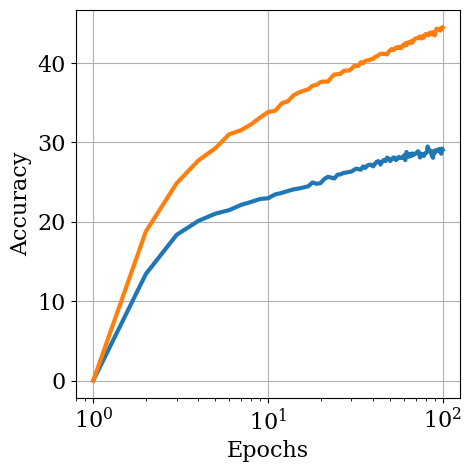

In [76]:
constraints = {
    'float_sequences':True,
    #'output_numeric':False,
    #'real_series':True,
    #'dimension':[1,2],
    #'mantissa_len':3,
    'prob_rand':0.,
    'train_noise':0,
    #'use_sympy':False,
    #'n_enc_layers':4,
    #'n_dec_layers':4,  
    #'prob_rand':0.0,
    #'curriculum_n_ops':False,
    #'optimizer':"adam_inverse_sqrt,lr=0.0006"
    #'batch_size':32,
}
selected_runs, selected_params = select_runs(runs, params, constraints)
latest = min([len(run['logs'])-1 for run in selected_runs])
latest = 100

plt.figure(figsize=(5,5))

for run in selected_runs[:]:
    args = run['args']
    times = np.array(range(len(run['logs'])))[:latest]
    loss       = [run['logs'][t]['valid1_recurrence_xe_loss']      for t in times]
    correct    = [run['logs'][t]['valid1_recurrence_correct']      for t in times]
    perfect    = [run['logs'][t]['valid1_recurrence_perfect']      for t in times]
    valid      = [run['logs'][t]['valid1_recurrence_beam_acc']     for t in times]
    additional = [run['logs'][t]['valid1_recurrence_additional_1'] for t in times]
    if valid: print(Path(args.dump_path), run['num_params'], len(times), valid[-1])
    label = 'With sympy' if args.use_sympy else 'Without sympy'
    #label = 'dim {}'.format(lab)
    y = valid
    plt.plot(times+1, y, label=label)

#plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xscale('log')

plt.tight_layout()
#plt.savefig(savedir+'simplification_loss_{}.pdf'.format('float' if args.float_sequences else 'int'))
plt.show()

29.3 & 48.7 & 60.7
44.3 & 53.5 & 60.0
43.5 & 27.7
70.9 & 40.7


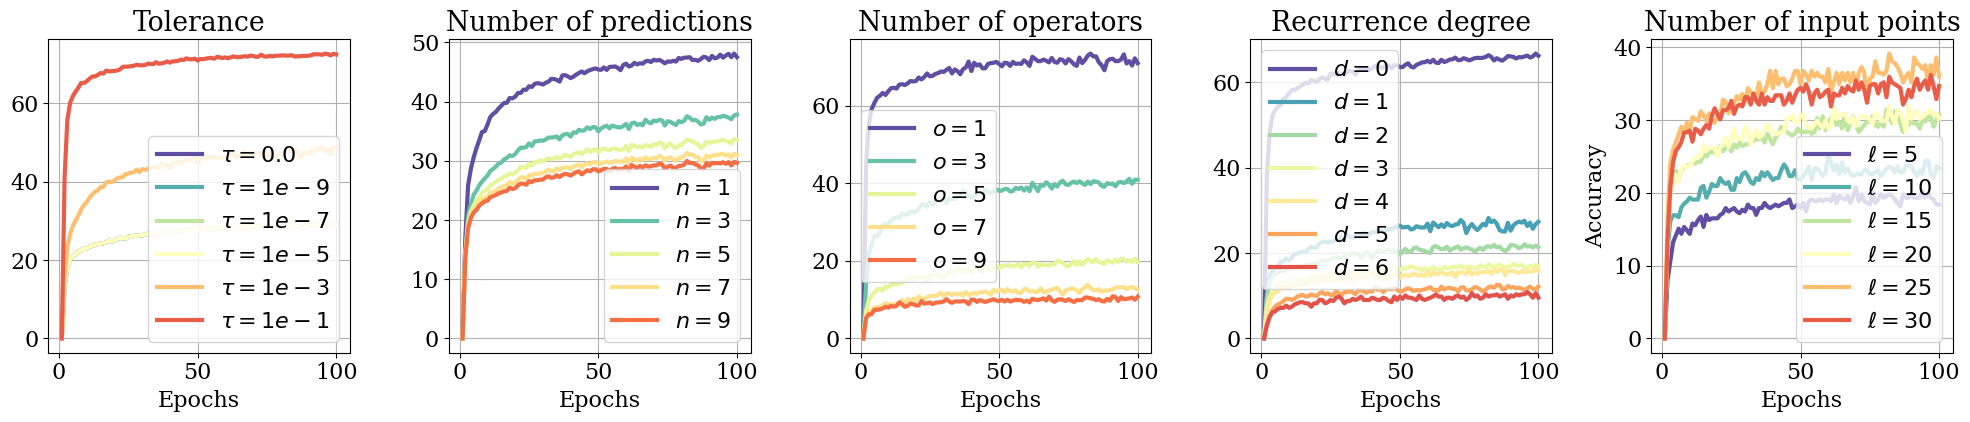

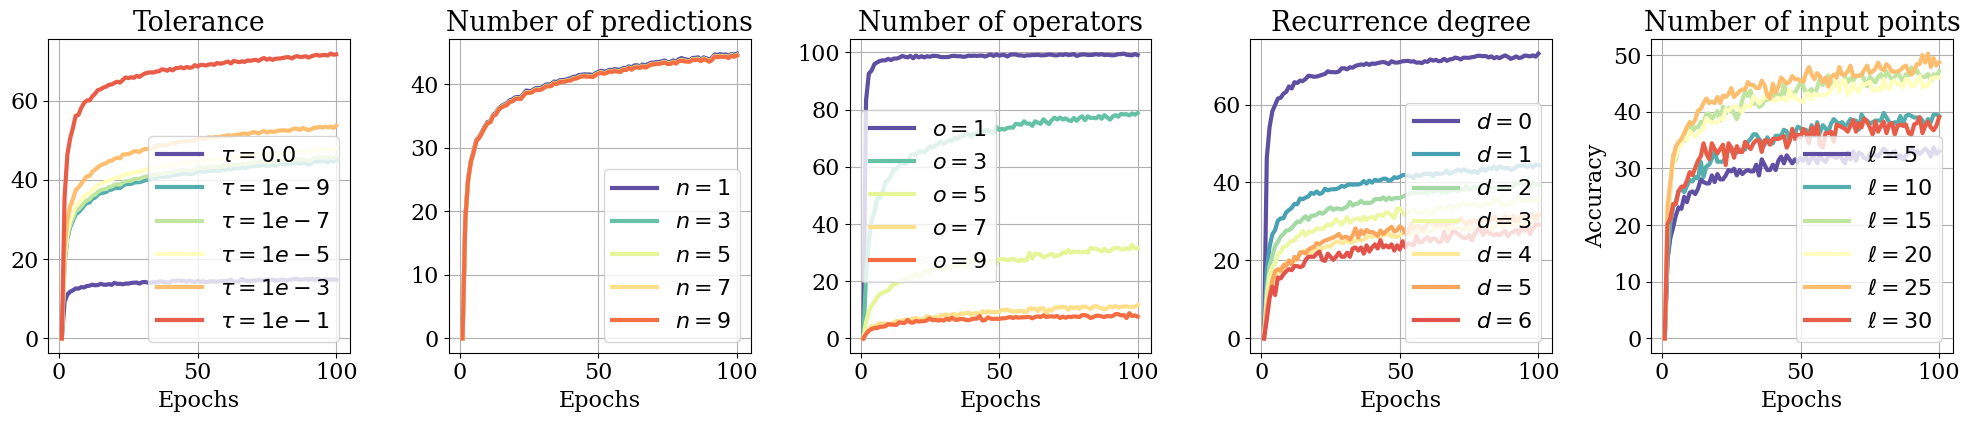

['valid1_recurrence_additional_1']
additional [29.31, 29.31, 29.31, 29.31, 29.31, 29.31, 29.32, 48.74, 60.69, 72.66]
n_predictions [47.72, 40.77, 37.64, 35.3, 33.56, 32.53, 31.34, 30.58, 29.89, 29.31]
ops [72.58726899383984, 56.91768826619965, 41.12, 25.75488454706927, 21.05751391465677, 16.619183285849953, 12.742980561555076, 9.929906542056075, 10.909090909090908, 9.65034965034965]
deg [65.6670113753878, 27.484909456740443, 22.19884271436086, 17.258176757132915, 15.894641235240691, 12.026143790849673, 10.875331564986737]
points_averaged [22.080015810285587, 24.892022064592933, 27.378943483504266, 30.281016277972725, 35.05663724451298, 34.28110240080742, 31.9693094629156]
['valid1_recurrence_additional_1']
additional [44.31, 44.69, 45.07, 45.57, 46.35, 47.66, 49.96, 53.5, 59.95, 71.52]
n_predictions [44.68, 44.5, 44.48, 44.45, 44.42, 44.39, 44.36, 44.36, 44.32, 44.31]
ops [99.28131416837782, 94.48336252189142, 78.72, 50.53285968028419, 31.261595547309835, 20.512820512820515, 10.9071274

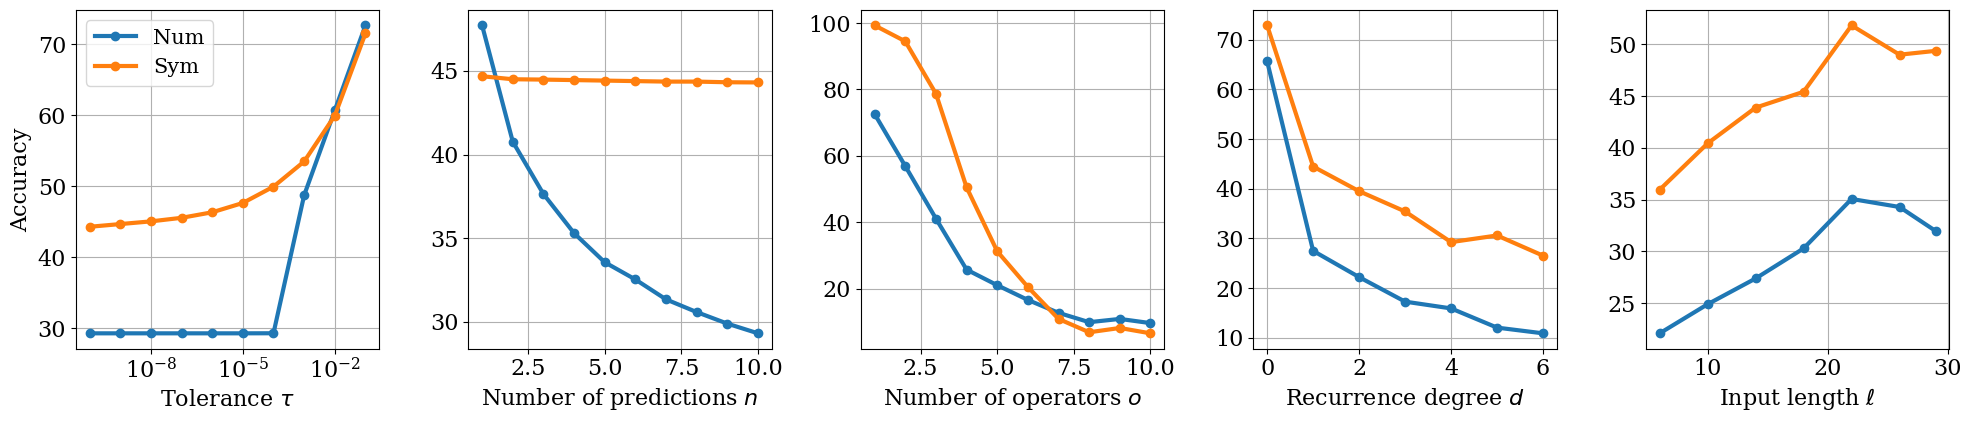

In [74]:
# chunk the inputs lens
chunk_size = 4
for run in selected_runs:
    keys = [k for k in run['logs'][0].keys() if 'points' in k]
    x = [int(k.split('_')[-1]) for k in keys]
    for length in x[::chunk_size]:
        lengths = range(length, min(max(x),length+chunk_size))
        if not lengths: continue
        keys_to_average = [f'valid1_recurrence_beam_acc_n_input_points_{l}' for l in lengths]
        average_acc =  np.mean([run['logs'][latest][k] for k in keys_to_average])
        run['logs'][latest][f'valid1_recurrence_beam_acc_n_input_points_averaged_{int(np.mean(lengths))}'] =  average_acc
        
keys = ['valid1_recurrence_additional_2', 'valid1_recurrence_additional_9', 'valid1_recurrence_additional_10']
for run in selected_runs:
    print(' & '.join(['{:.1f}'.format(run['logs'][latest][key]) for key in keys]))

key_list = [['valid1_recurrence_beam_acc_n_ops_{}'.format(i) for i in range(1,6)], ['valid1_recurrence_beam_acc_n_ops_{}'.format(i) for i in range(1,11)]]
for run in selected_runs:
    accs = []
    for keys in key_list:
        accs.append(np.mean([run['logs'][latest][key] for key in keys]))
    print(' & '.join(['{:.1f}'.format(x) for x in accs]))
        
#########
metrics = ['additional', 'n_predictions', 'ops', 'deg', 'points']
legends = ['\\tau','n','o', 'd', '\ell']
labels = ['Tolerance', 'Number of predictions', 'Number of operators', 'Recurrence degree', 'Number of input points']

for run in selected_runs:
    args = run['args']
    fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
    for i, metric in enumerate(metrics):
        keys = [k for k in run['logs'][0].keys() if metric in k]
        keys = keys[::max(1,len(keys)//5)]
        for j, key in enumerate(keys):
            label = int(key.split('_')[-1])
            if metric == 'additional': label = args.more_tolerance.split(',')[int(label)-1]
            acc = [run['logs'][t][key] for t in range(len(run['logs'][:latest]))]
            axarr[i].plot(range(1, len(acc)+1), acc, label='${}={}$'.format(legends[i],label), color = cmap(j/len(keys)))
        axarr[i].set_title(labels[i])
        axarr[i].legend()
    for ax in axarr:
        #ax.set_xscale('log')
        ax.set_xlabel('Epochs')
    #for n, ax in enumerate(axarr):
    #    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
    axarr[-1].set_ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig(savedir+'acc_vs_time_{}_{}.pdf'.format('float' if args.float_sequences else 'int', 'num' if args.output_numeric else 'sym'))
    plt.show()    

##########
metrics = ['additional', 'n_predictions', 'ops', 'deg', 'points_averaged']
labels = [ 'Tolerance $\\tau$', 'Number of predictions $n$','Number of operators $o$', 'Recurrence degree $d$', 'Input length $\ell$']
        
    
suffix = ''
fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
for run in selected_runs:
    args = run['args']
    log = run['logs'][latest]
    for i, metric in enumerate(metrics):
        if metric == 'ops':
            keys = [k for k in list(log.keys())[::args.dimension] if metric in k]
        else:
            keys = [k for k in log.keys() if metric in k]
        if metric == 'additional':
            keys = keys[1:]
            x = [eval(x) for x in args.more_tolerance.split(',')[1:]]
            print(["valid1_recurrence_additional_1"])
            axarr[i].set_xscale('log')
        elif metric == 'ops':
            x = [int(k.split('_')[-1])//args.dimension for k in keys]
        #elif metric == 'points_averaged':
        #    x = [int(k.split('_')[-1])*args.dimension for k in keys]
        else:
            x = [int(k.split('_')[-1]) for k in keys]
        y = [log[k] for k in keys]
        print(metric, y)
        label = 'Num' if run['args'].output_numeric else 'Sym'
        if args.prob_rand: 
            label += ' $p_{{rand}}={}$'.format(args.prob_rand)
            suffix = '_rand'
        elif args.dimension>1: 
            label += ' dim={}'.format(args.dimension)
            suffix = '_multidim'
        axarr[i].plot(x, y, label = label, marker='o')
        axarr[i].set_xlabel(r'{}'.format(labels[i]))
        #axarr[i].set_ylim(bottom=0, top=100)
        #axarr[i].set_yscale('symlog')
#for n, ax in enumerate(axarr):
#    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
axarr[0].set_ylabel('Accuracy')
axarr[0].legend(fontsize=15)
plt.tight_layout()
title = 'acc_vs_difficulty_{}'.format('float' if args.float_sequences else 'int') + suffix + '.pdf'
plt.savefig(savedir+title)
plt.show()    

# Evaluate run

In [ ]:
for run in selected_runs:
    
    res = {}
    
    for group, ops in od_groups.items():
        
        args = run['args']
        new_args = {
        'eval_size': 128,
        'batch_size_eval': 1000,
        'more_tolerance':1e-10,0.001,0.01',
        '.max_ops': 5,
        '.float_constants': None,
        '.eval_noise': 0.0,
        '.eval_noise_type': 'additive',

        'extra_unary_operators': 'id',
        'operators_to_remove': ','.join(set(all_ops)-set(id_groups['base']+ops)),
        
        'operators_to_remove': '.join(set(all_ops)-set(id_groups['base'])),
        'extra_unary_operators': ','.join(ops)
        }
        
        scores = eval_run(run, new_args)
        print(new_args.operators_to_remove, ' & '.join(['{:.1f}'.format(scores['valid1_recurrence_additional_'+str(i)]) for i in range(1,4)]))
        res[group] = scores['valid1_recurrence_additional_1']

    print(res)

In [ ]:
perfs_num = {'base': 34.375, 'div': 26.5625, 'sqrt': 35.15625, 'exp': 39.0625, 'trig': 29.6875}
perfs_sym = {'base': 64.84375, 'div': 57.8125, 'sqrt': 61.71875, 'exp': 57.8125, 'trig': 50.0}


perfs_num = {'poly': 37.5, 'hyper': 32.03125, 'fresnel': 28.125, 'bessel': 23.4375}
perfs_sym = {'poly': 79.6875, 'hyper': 34.375, 'fresnel': 27.34375, 'bessel': 27.34375}


labels = perfs_num.keys()
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(4,5))
rects1 = ax.bar(x - width/2, [round(x) for x in perfs_num.values()], width, label='Numeric')
rects2 = ax.bar(x + width/2, [round(x) for x in perfs_sym.values()], width, label='Symbolic')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, fontsize=15)
ax.bar_label(rects1, fontsize=12, rotation=0)
ax.bar_label(rects2, fontsize=12, rotation=0)
ax.set_ylim(top=max(list(rects1.datavalues)+list(rects2.datavalues))+20)
ax.legend()
ax.grid(False)
fig.tight_layout()
plt.savefig(savedir+'acc_vs_group_{}.pdf'.format('id' if 'base' in perfs_num else 'ood'))
plt.show()

In [11]:
for run in selected_runs[::-1]:
    
    #for eval_noise in [0, 0.1, 0.5]:
    for prob_rand in [0, 0.1]:

        new_args = {'eval_size':1000,
                    'batch_size_eval': 128,
                    'more_tolerance': '1e-10,0.001,0.01',
                    'prob_rand': prob_rand,
                    'eval_noise': 0,#eval_noise,
                    'eval_vebose': 2,
                    'eval_vebose_print': True,
                    'max_ops':4,
                    'min_len':30,
                   }

        scores = eval_run(run, new_args)
        print(' & '.join(['{:.1f}'.format(scores['valid1_recurrence_additional_'+str(i)]) for i in range(1,4)]))
        #print(scores)

<module 'src' from '/checkpoint/sdascoli/recur/final/random/float_sequences_True_output_numeric_False_dimension_1_prob_rand_0.1_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/src/__init__.py'>


Reloading checkpoint from /checkpoint/sdascoli/recur/final/random/float_sequences_True_output_numeric_False_dimension_1_prob_rand_0.1_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 89 / iteration 834375 ...


81.3 & 84.5 & 87.5
<module 'src' from '/checkpoint/sdascoli/recur/final/random/float_sequences_True_output_numeric_False_dimension_1_prob_rand_0.1_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/src/__init__.py'>


Reloading checkpoint from /checkpoint/sdascoli/recur/final/random/float_sequences_True_output_numeric_False_dimension_1_prob_rand_0.1_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 89 / iteration 834375 ...


22.8 & 24.1 & 27.1
<module 'src' from '/checkpoint/sdascoli/recur/final/random/float_sequences_True_output_numeric_False_dimension_1_prob_rand_0.1_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/src/__init__.py'>


Reloading checkpoint from /checkpoint/fcharton/recur/final/large/float_sequences_True_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 118 / iteration 1106250 ...


84.3 & 87.4 & 89.9
<module 'src' from '/checkpoint/sdascoli/recur/final/random/float_sequences_True_output_numeric_False_dimension_1_prob_rand_0.1_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/src/__init__.py'>


Reloading checkpoint from /checkpoint/fcharton/recur/final/large/float_sequences_True_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 118 / iteration 1106250 ...


2.6 & 3.8 & 6.6


# In distribution

In [5]:
run = selected_runs[-1]
new_args =  {'eval_noise':0.1,
             #'prob_rand':0,
             'cpu':True
            }
env, modules, trainer, evaluator = load_run(run, new_args)
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']

<module 'src' from '/checkpoint/sdascoli/recur/final/random/float_sequences_True_output_numeric_False_dimension_1_prob_rand_0.1_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/src/__init__.py'>


Reloading checkpoint from /checkpoint/sdascoli/recur/final/random/float_sequences_True_output_numeric_False_dimension_1_prob_rand_0.1_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 89 / iteration 834375 ...


In [ ]:
n = 2
failure_only = False
success_only = True
use_sympy = False

fig, axarr = plt.subplots(n,n,figsize=(n*3,n*3))
n_errors = 0
for i in range(n):
    for j in range(n):
        while True:
            try:
                tree, pred_trees, seq, pred_seqs, scores, mses = predict(env, modules, gen_kwargs={'nb_ops':3, 'length':25}, verbose=True)
                pred_tree, pred_seq, score = pred_trees[0], pred_seqs[0], scores[0]
                if args.prob_rand and "rand" not in tree.prefix(): continue
                print(i,j)
                if np.isnan(np.sum(seq)) or np.isnan(np.sum(pred_seq)): continue
                ending = np.array(seq[-5:]); gaps = abs(ending[1:]-ending[:-1])
                if len(set(gaps))<2: continue # discard uninteresting series                            
                if failure_only:
                    if abs((seq[-1]-pred_seq[-1])/seq[-1])<0.1: continue
                if success_only: 
                    if abs((seq[-1]-pred_seq[-1])/seq[-1])>0.001: continue

                confidence = 10**score
                if use_sympy: 
                    pred, true = sympy_infix(pred_tree), sympy_infix(tree)
                else:
                    pred, true = readable_infix(pred_tree), readable_infix(tree)
                #axarr[i,j].plot(series)
                #axarr[i,j].plot(preds, ls='--')
                length = len(seq)//args.dimension
                axarr[i,j].axvspan(0, length//2, alpha=0.1, color='green')
                axarr[i,j].axvspan(length//2, len(seq)//args.dimension, alpha=0.1, color='red')
                for dim in range(args.dimension):
                    axarr[i,j].plot(range(length), seq[dim::args.dimension], color='C%d'%dim, lw=2, label='True' if dim==0 else '')
                    axarr[i,j].plot(range(length), pred_seq[dim::args.dimension], color='C%d'%dim, lw=8, alpha=.5, label='Pred' if dim==0 else '')
                break
            except Exception as e:
                print(e, end=' ')
                #if n_errors>1000: break
                n_errors += 1
        axarr[i,j].set_title(f'True: {true}\nPred: {pred}\nConfidence: {confidence:.2}', fontsize=10)
        #axarr[i,j].set_yscale('symlog')
        #axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])    
axarr[-1,-1].legend(fontsize=12)
        
plt.tight_layout()
title = 'failure' if failure_only else 'success'
title += '_{}'.format('float' if args.float_sequences else 'int', args.dimension)
if args.prob_rand: 
    title += '_rand'
elif args.dimension>1: 
    suffix += '_multidim'
title += '.pdf'
#plt.savefig(savedir+title)
plt.show()

# Out of distribution

In [ ]:
run = selected_runs[-1]
env, modules, trainer, evaluator = load_run(run, epoch=None, new_args={'cpu':True})
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']

((sin(x1) - cos(n)) / sqrt((n + n))): 0.2914 8.21e-02 4.47e-01 
(((sqrt(n) * cos((-3 - n))) - (x1 / n)) / n): 0.1848 8.29e-02 3.03e-01 
((x1 - cos(n)) / sqrt(((n + n) + x1))): 0.1845 8.29e-02 4.47e-01 
((x1 - cos(n)) / sqrt((n + (n + x1)))): 0.1851 8.29e-02 4.47e-01 
((x1 - cos(n)) / sqrt((n + n))): 0.4057 8.42e-02 4.47e-01 
((x1 - cos(n)) / sqrt((n + (n - x1)))): 0.2262 8.66e-02 4.47e-01 
((x1 - cos(n)) / sqrt(((n + n) - x1))): 0.2078 8.66e-02 4.47e-01 
((x1 - cos(n)) / sqrt(((n - x1) + n))): 0.2342 8.66e-02 4.47e-01 
((x1 - cos(n)) * (sqrt(n) / (n + log(n)))): 0.2312 9.00e-02 3.05e-01 
((sin(n) - (cos(n) * n)) / (n * sqrt(n))): 0.2375 2.26e-01 1.40e-01 
((sin(n) - (cos(n) * n)) / (sqrt(n) * n)): 0.2530 2.26e-01 1.40e-01 
(((sin(n) / n) - cos(n)) / sqrt(n)): 0.2954 2.26e-01 1.40e-01 
((sin(n) - (cos(n) * n)) / (n * sqrt((n - g)))): 0.1888 4.21e-01 1.34e-01 
((sin(n) / n) - (cos(n) / sqrt(n))): 0.3083 4.69e-01 1.55e-02 
((x1 - cos(n)) / sqrt(((n + n) + tan(n)))): 0.2334 nan nan 
((x1 -

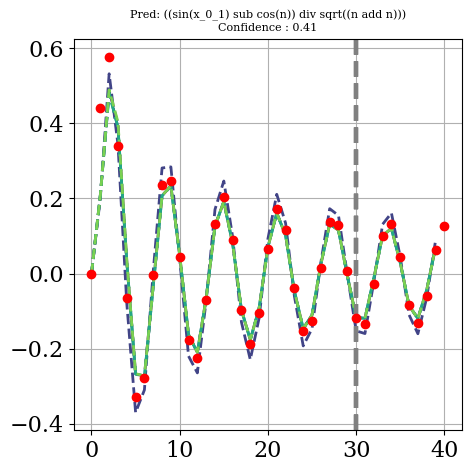

In [81]:
from scipy.special import erf, factorial, gamma
xi = np.random.randn
f = lambda n : scipy.special.j1(n)
#f = lambda n : np.exp(-n)
#f = lambda n : np.cosh(n)
#f = lambda n : np.arctanh(1/(n+1))
#f = lambda n : n*(n+1)*(2*n+1)/6
#f = lambda n : (n*(n+1)/2)
#f = lambda n : factorial(n) #+ xi()
#f = lambda n : (1+n+n**2)*np.exp(np.arctan(n))
#f = lambda n : np.exp(n)*np.sqrt(n)
#f = lambda n : 2**n
#f = lambda n : n**2*(1+np.random.randn())
#f = lambda n : 10**n
#f = lambda n : np.tan(n)*np.random.normal()
#f = lambda n : scipy.special.dawsn(n)
#f = lambda n : np.exp(np.pi*np.sqrt(2*n/3))/(4*n*np.sqrt(3)) 
#f = lambda n : 1.1*n
# np.exp(np.pi*np.sqrt(2*n/3))/(4*n*np.sqrt(3))
#f = lambda n : 1
#f = lambda n : 9.1*n
g = lambda n,x,y : x+y+xi()

length = 30
pred_len = 10

fig, ax = plt.subplots(1,1,figsize=(5,5))
seq = [f(n) for n in range(length+pred_len+1)]
#seq = [1,1]
#for n in range(2,length+pred_len+1):
#    seq.append(g(n, seq[-1], seq[-2]))
#seq =[1,1,2,5,14,42,132,429,1430,4862,16796,58786, 208012,742900,2674440,9694845,35357670,129644790, 477638700,1767263190,6564120420,24466267020, 91482563640,343059613650,1289904147324, 4861946401452,18367353072152,69533550916004, 263747951750360,1002242216651368,3814986502092304]
#seq = [1, -24, 252, -1472, 4830, -6048, -16744, 84480, -113643, -115920, 534612, -370944, -577738, 401856, 1217160, 987136, -6905934, 2727432, 10661420, -7109760, -4219488, -12830688, 18643272, 21288960, -25499225, 13865712, -73279080]

tree, pred_trees, _, pred_seqs, scores, mses = predict(env, modules, seq=seq[:length], beam_length_penalty=None, beam_size=20, verbose=False, pred_len=pred_len, nonrec_only=False, sort_mse=True)#, rec_only=True)

for pred_seq, pred_tree, mse, score in zip(pred_seqs, pred_trees, mses, scores):
    asymptotic_error = (seq[-1] - pred_seq[-1])/seq[-1]
    print("{}: {:.4f} {:.2e} {:.2e} ".format(readable_infix(pred_tree), 10**score, mse, asymptotic_error))
    

n_plot = 5
for i in range(min(n_plot, len(pred_seqs))):
    pred_seq = pred_seqs[i]
    confidence = 10**scores[i]
    #pred = readable_infix(pred)
    ax.plot(pred_seq, ls='--', color=plt.cm.viridis(i/n_plot), lw=2)
    #ax.plot([n * np.log(n) for n in range(1,length+1)], ls='--')
    ax.axvline(x=length, ls='--', color='grey')
    pred_tree = pred_trees[0].infix()
    plt.title(f'Pred: {pred_tree}\nConfidence : {confidence:.2f}', fontsize=8)
    #plt.yscale('symlog')
    #plt.xticks([])
    #plt.yticks([])
ax.plot(seq, ls="none", marker='o', color='red')

plt.tight_layout()
plt.show()

# Embeddings

In [ ]:
run = selected_runs[1]
env, modules, trainer, evaluator = load_run(run)
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']

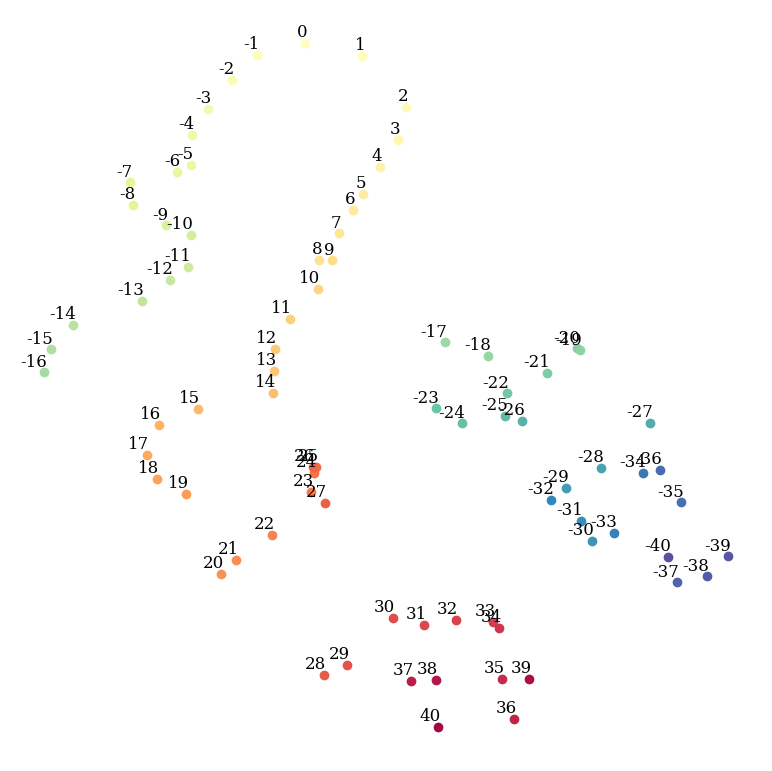

In [91]:
def get_labels_tokens(embeddings, env):
    "Creates and TSNE model and plots it"
    labels = []; tokens = []
    if args.float_sequences: smallest, largest = -40,40
    else: smallest, largest = 0, 80
    for number in range(smallest, largest+1):
        if args.float_sequences: word = 'E'+str(number-args.float_precision-1)
        else: word = str(number)
        idx = env.input_word2id[word]
        tokens.append(embeddings[idx])
        labels.append(str(number))
    return labels, tokens

def get_output_labels_tokens(embeddings, env):
    "Creates and TSNE model and plots it"
    labels = []; tokens = []
    for word, idx in env.output_word2id.items():
        tokens.append(embeddings[idx])
        labels.append(word)
    return labels, tokens
            
def tsne_plot_2d(embeddings, env, n_words=500):
    
    labels, tokens = get_labels_tokens(embeddings, env) 
    tsne_model = TSNE( n_components=2, perplexity=40, init='pca', n_iter=1000, random_state=0)
    new_values = tsne_model.fit_transform(tokens)

    x = []; y = []
    for value in new_values:
        x.append(value[0]); y.append(value[1])
        
    plt.figure(figsize=(8, 8)) 
    for i in range(len(x))[:n_words]:
        plt.scatter(x[i],y[i], color=cmap(i/min(n_words, len(x))))
        plt.annotate(labels[i], xy=(x[i], y[i]), fontsize=12, xytext=(2, 2), textcoords='offset points', ha='right', va='bottom')
    plt.axis(False)
    plt.tight_layout()
    plt.savefig(savedir+'embeddings_{}_{}.pdf'.format('float' if args.float_sequences else 'int', 'num' if args.output_numeric else 'sym'))
    plt.show()
       
tsne_plot_2d(encoder.embeddings.weight.cpu().detach().numpy(), env)

In [ ]:
plt.figure(figsize=(15,15))
embeddings = encoder.embeddings.weight.cpu().detach()
if args.float_sequences: smallest, largest = -80, 80
else: smallest, largest = 0, 80
similarity = torch.zeros(largest-smallest, largest-smallest)

for i1, w1 in enumerate(range(smallest, largest)):
    if args.float_sequences: w1 = 'E'+str(w1-args.float_precision)
    for i2, w2 in enumerate(range(smallest, largest)):
        if i1==i2: continue
        if args.float_sequences: w2 = 'E'+str(w2-args.float_precision)
        j1 = env.input_word2id[str(w1)]
        j2 = env.input_word2id[str(w2)]
        similarity[i1,i2] = torch.dot(embeddings[j1], embeddings[j2])/embeddings[j1].norm()/embeddings[j2].norm()

plt.matshow(similarity)
plt.grid(False)

nticks = 5
ticks = np.linspace(0,len(similarity), nticks)
labels = np.linspace(smallest, largest, nticks).astype(int)
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

plt.tight_layout()
plt.savefig(savedir+'embedding_similarities_{}_{}.pdf'.format('float' if args.float_sequences else 'int', 'num' if args.output_numeric else 'sym'))
plt.show()

# OEIS

In [31]:
from oeis import load_oeis
lines, ids = load_oeis(length=29, path="/private/home/sdascoli/recur/OEIS_very_easy.txt")

run = selected_runs[-1]
args = run['args']
new_args = {'beam_size':10,
           'cpu':False}
env, modules, trainer, evaluator = load_run(run, new_args)
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']

9940 29.0
<module 'src' from '/checkpoint/sdascoli/recur/paper/all/float_sequences_False_output_numeric_False_batch_size_32_use_sympy_False/src/__init__.py'>


Reloading checkpoint from /checkpoint/sdascoli/recur/paper/all/float_sequences_False_output_numeric_False_batch_size_32_use_sympy_False/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 70 / iteration 656250 ...
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f09e4b44050>
Traceback (most recent call last):
  File "/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/private/home/sdascoli/.conda/envs/bert/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/private/home/sdascoli/.conda/envs/bert/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/private/home/sdascoli/.conda/envs/bert/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not 

In [9]:
batch_size = 8
max_preds = 15

print('{:.0f} batches'.format(len(lines)/batch_size))
corrects = {k:0 for k in [1,max_preds]}
tol1     = {k:0 for k in [1,max_preds]}
tol2     = {k:0 for k in [1,max_preds]}
good = []
for ibatch, batch in enumerate(chunks(lines, batch_size)):
    inputs = [seq[:-max_preds] for seq in batch]
    #try: 
    preds, pred_series = predict_batch(env, modules, inputs, pred_len=max_preds,)
    #except: continue
    for i in range(len(pred_series)): 
        pred = pred_series[i]
        seq_len = len(batch[i])
        if pred is None: continue
        true = batch[i][-max_preds:]
        #print(true, pred)
        for key in corrects:
            try: 
                max_error = max([abs(float(x-y)/float(y+1e-10)) for x,y in zip(true[:key], pred[:key])])
            except Exception as e: print(e); continue
            corrects[key] += int(max_error<1e-10)
            tol1[key] += int(max_error<0.001)
            tol2[key] += int(max_error<0.01)
            
        if max_error<0.01:
            good.append(ibatch*batch_size+i)
        
    if ibatch%10==0: 
        total = (ibatch+1)*batch_size
        print('batch {}: '.format(ibatch),
              ' '.join(['{}: {:.1f}'.format(k, 100*corrects[k]/total) for k in corrects]),
              #' '.join(['{}: {:.1f}'.format(k, 100*tol1[k]/total) for k in tol1]),
              ' '.join(['{}: {:.1f}'.format(k, 100*tol2[k]/total) for k in tol2]))

1242 batches
batch 0:  1: 50.0 15: 37.5 1: 50.0 15: 37.5
batch 10:  1: 48.9 15: 34.1 1: 53.4 15: 34.1
batch 20:  1: 47.0 15: 32.1 1: 51.2 15: 32.1
batch 30:  1: 44.4 15: 31.0 1: 49.2 15: 31.5
batch 40:  1: 48.5 15: 31.1 1: 52.4 15: 31.7
batch 50:  1: 49.3 15: 31.9 1: 53.9 15: 32.8
batch 60:  1: 48.2 15: 30.5 1: 52.0 15: 31.4
batch 70:  1: 45.1 15: 27.8 1: 48.8 15: 28.7
batch 80:  1: 46.6 15: 30.1 1: 49.8 15: 31.0
batch 90:  1: 47.7 15: 30.5 1: 50.5 15: 31.3
batch 100:  1: 50.6 15: 34.5 1: 53.3 15: 35.4
batch 110:  1: 53.3 15: 37.8 1: 55.7 15: 38.6
batch 120:  1: 51.9 15: 35.5 1: 54.3 15: 36.5
batch 130:  1: 53.1 15: 37.8 1: 55.6 15: 38.8
batch 140:  1: 55.1 15: 39.7 1: 57.4 15: 40.7
batch 150:  1: 56.3 15: 41.9 1: 58.6 15: 42.8
batch 160:  1: 54.7 15: 40.8 1: 57.1 15: 41.8
batch 170:  1: 55.3 15: 40.9 1: 57.6 15: 41.8
batch 180:  1: 55.3 15: 40.6 1: 57.5 15: 41.5
batch 190:  1: 55.2 15: 40.4 1: 57.3 15: 41.3
batch 200:  1: 54.2 15: 39.6 1: 56.2 15: 40.5
batch 210:  1: 53.3 15: 38.9 1: 

In [ ]:
batch 0:  1: 62.5 15: 25.0 1: 62.5 15: 25.0
batch 10:  1: 55.7 15: 27.3 1: 60.2 15: 27.3
batch 20:  1: 46.4 15: 24.4 1: 50.0 15: 25.0
batch 30:  1: 41.5 15: 23.8 1: 44.4 15: 24.2
batch 40:  1: 42.1 15: 25.3 1: 45.4 15: 25.9
batch 50:  1: 41.4 15: 23.5 1: 44.4 15: 24.0
batch 60:  1: 39.3 15: 21.9 1: 42.4 15: 22.5
batch 70:  1: 37.5 15: 20.6 1: 40.8 15: 21.1
batch 80:  1: 34.4 15: 18.7 1: 38.1 15: 19.1
batch 90:  1: 33.7 15: 17.7 1: 37.0 15: 18.1
batch 100:  1: 35.9 15: 18.2 1: 39.2 15: 18.6
batch 110:  1: 36.1 15: 17.6 1: 39.2 15: 17.9
batch 120:  1: 36.5 15: 18.1 1: 39.4 15: 18.5
batch 130:  1: 37.2 15: 18.0 1: 40.1 15: 18.5
batch 140:  1: 37.8 15: 18.9 1: 41.0 15: 19.7
batch 150:  1: 37.2 15: 18.8 1: 40.3 15: 19.5
batch 160:  1: 37.1 15: 18.2 1: 40.3 15: 19.0
batch 170:  1: 37.1 15: 18.2 1: 40.6 15: 19.1
batch 180:  1: 36.0 15: 17.5 1: 39.6 15: 18.4
batch 190:  1: 35.9 15: 17.3 1: 39.5 15: 18.3
batch 200:  1: 37.2 15: 18.7 1: 40.8 15: 19.7
batch 210:  1: 37.9 15: 19.0 1: 41.5 15: 20.1
batch 220:  1: 38.3 15: 19.5 1: 41.9 15: 20.6
batch 230:  1: 39.1 15: 20.8 1: 42.5 15: 22.0
batch 240:  1: 41.0 15: 23.3 1: 44.2 15: 24.4
batch 250:  1: 40.3 15: 22.5 1: 43.5 15: 23.6
batch 260:  1: 40.2 15: 22.3 1: 43.5 15: 23.5
batch 270:  1: 40.2 15: 21.8 1: 43.5 15: 23.0
batch 280:  1: 41.2 15: 21.6 1: 44.4 15: 22.7
batch 290:  1: 41.5 15: 21.5 1: 44.6 15: 22.6
batch 300:  1: 41.2 15: 21.4 1: 44.2 15: 22.6
batch 310:  1: 42.8 15: 23.7 1: 45.7 15: 24.8
batch 320:  1: 42.8 15: 23.4 1: 45.7 15: 24.5
batch 330:  1: 43.1 15: 23.3 1: 45.9 15: 24.4
batch 340:  1: 42.7 15: 23.3 1: 45.5 15: 24.5
batch 350:  1: 43.1 15: 23.9 1: 45.8 15: 25.0
batch 360:  1: 43.7 15: 24.6 1: 46.3 15: 25.7
batch 370:  1: 43.9 15: 25.1 1: 46.4 15: 26.2
batch 380:  1: 43.5 15: 24.7 1: 46.1 15: 25.8
batch 390:  1: 43.7 15: 24.4 1: 46.3 15: 25.5
batch 400:  1: 43.1 15: 23.8 1: 45.7 15: 24.9
batch 410:  1: 42.9 15: 23.5 1: 45.5 15: 24.6
batch 420:  1: 43.0 15: 23.6 1: 45.5 15: 24.8
batch 430:  1: 42.6 15: 23.5 1: 45.2 15: 24.6
batch 440:  1: 42.8 15: 23.4 1: 45.4 15: 24.6
batch 450:  1: 42.6 15: 23.0 1: 45.1 15: 24.1
batch 460:  1: 42.3 15: 22.5 1: 44.8 15: 23.6
batch 470:  1: 42.4 15: 22.0 1: 44.8 15: 23.1
batch 480:  1: 42.2 15: 21.6 1: 44.5 15: 22.6
batch 490:  1: 42.3 15: 21.5 1: 44.6 15: 22.5
batch 500:  1: 42.2 15: 21.2 1: 44.5 15: 22.2
batch 510:  1: 42.3 15: 21.2 1: 44.7 15: 22.2
batch 520:  1: 42.2 15: 21.2 1: 44.6 15: 22.2
batch 530:  1: 43.3 15: 22.7 1: 45.6 15: 23.7
batch 540:  1: 43.7 15: 23.1 1: 46.0 15: 24.2
batch 550:  1: 43.4 15: 22.9 1: 45.7 15: 23.9
batch 560:  1: 43.1 15: 22.7 1: 45.4 15: 23.7
batch 570:  1: 42.7 15: 22.4 1: 44.9 15: 23.4
batch 580:  1: 42.2 15: 22.0 1: 44.5 15: 23.0
batch 590:  1: 42.2 15: 22.1 1: 44.5 15: 23.1
batch 600:  1: 42.0 15: 22.0 1: 44.2 15: 22.9
batch 610:  1: 41.8 15: 21.7 1: 44.1 15: 22.6
batch 620:  1: 41.3 15: 21.4 1: 43.6 15: 22.3
batch 630:  1: 41.1 15: 21.2 1: 43.4 15: 22.1
batch 640:  1: 40.9 15: 20.9 1: 43.2 15: 21.8
batch 650:  1: 41.2 15: 20.8 1: 43.5 15: 21.7
batch 660:  1: 41.6 15: 20.7 1: 43.8 15: 21.5
batch 670:  1: 41.5 15: 20.4 1: 43.6 15: 21.3
batch 680:  1: 40.9 15: 20.1 1: 43.1 15: 21.0
batch 690:  1: 40.4 15: 19.8 1: 42.5 15: 20.7
batch 700:  1: 39.9 15: 19.6 1: 42.0 15: 20.4
batch 710:  1: 39.5 15: 19.3 1: 41.7 15: 20.1
batch 720:  1: 39.7 15: 19.6 1: 41.9 15: 20.4
batch 730:  1: 39.7 15: 19.7 1: 41.8 15: 20.5
batch 740:  1: 39.6 15: 19.6 1: 41.8 15: 20.4
batch 750:  1: 39.7 15: 19.6 1: 41.8 15: 20.4
batch 760:  1: 39.7 15: 19.5 1: 41.8 15: 20.3
batch 770:  1: 39.6 15: 19.4 1: 41.6 15: 20.1
batch 780:  1: 39.5 15: 19.2 1: 41.6 15: 19.9
batch 790:  1: 39.5 15: 19.1 1: 41.5 15: 19.8
batch 800:  1: 39.4 15: 19.0 1: 41.4 15: 19.7
batch 810:  1: 39.4 15: 18.8 1: 41.4 15: 19.5
batch 820:  1: 39.4 15: 18.6 1: 41.4 15: 19.3
batch 830:  1: 39.4 15: 18.5 1: 41.3 15: 19.2
batch 840:  1: 39.1 15: 18.4 1: 41.0 15: 19.1
batch 850:  1: 38.9 15: 18.2 1: 40.8 15: 18.9
batch 860:  1: 38.5 15: 18.0 1: 40.4 15: 18.7
batch 870:  1: 38.5 15: 17.9 1: 40.4 15: 18.6
batch 880:  1: 38.4 15: 17.8 1: 40.2 15: 18.5
batch 890:  1: 38.3 15: 17.8 1: 40.2 15: 18.5
batch 900:  1: 38.9 15: 18.7 1: 40.8 15: 19.3
batch 910:  1: 39.6 15: 19.5 1: 41.4 15: 20.2
batch 920:  1: 40.2 15: 20.3 1: 42.0 15: 21.0
batch 930:  1: 40.7 15: 21.1 1: 42.5 15: 21.7
batch 940:  1: 41.2 15: 21.7 1: 43.0 15: 22.3
batch 950:  1: 41.0 15: 21.5 1: 42.8 15: 22.2
batch 960:  1: 40.8 15: 21.3 1: 42.6 15: 22.0
batch 970:  1: 40.5 15: 21.2 1: 42.3 15: 21.8
batch 980:  1: 40.3 15: 21.0 1: 42.1 15: 21.7
batch 990:  1: 40.1 15: 20.9 1: 41.9 15: 21.5
batch 1000:  1: 40.1 15: 20.8 1: 41.8 15: 21.4
batch 1010:  1: 39.8 15: 20.6 1: 41.5 15: 21.2
batch 1020:  1: 39.6 15: 20.4 1: 41.3 15: 21.1
batch 1030:  1: 39.4 15: 20.3 1: 41.2 15: 20.9
batch 1040:  1: 39.4 15: 20.4 1: 41.2 15: 21.0
batch 1050:  1: 39.5 15: 20.5 1: 41.3 15: 21.1
batch 1060:  1: 39.3 15: 20.3 1: 41.1 15: 20.9
batch 1070:  1: 39.2 15: 20.2 1: 41.0 15: 20.8
batch 1080:  1: 39.2 15: 20.1 1: 40.9 15: 20.7
batch 1090:  1: 39.0 15: 20.0 1: 40.8 15: 20.6
int too large to convert to float
batch 1100:  1: 39.0 15: 19.9 1: 40.7 15: 20.5
batch 1110:  1: 38.9 15: 19.8 1: 40.6 15: 20.4
batch 1120:  1: 38.8 15: 19.7 1: 40.6 15: 20.3
batch 1130:  1: 38.8 15: 19.8 1: 40.6 15: 20.4
batch 1140:  1: 38.9 15: 19.8 1: 40.7 15: 20.3
batch 1150:  1: 38.9 15: 19.7 1: 40.7 15: 20.3
batch 1160:  1: 38.8 15: 19.7 1: 40.6 15: 20.3
batch 1170:  1: 38.7 15: 19.6 1: 40.5 15: 20.2
batch 1180:  1: 38.5 15: 19.5 1: 40.3 15: 20.1
batch 1190:  1: 38.5 15: 19.4 1: 40.3 15: 20.0
batch 1200:  1: 38.5 15: 19.4 1: 40.3 15: 20.0
batch 1210:  1: 38.4 15: 19.3 1: 40.2 15: 19.9
batch 1220:  1: 38.3 15: 19.2 1: 40.1 15: 19.8
batch 1230:  1: 38.3 15: 19.2 1: 40.1 15: 19.9
batch 1240:  1: 38.3 15: 19.1 1: 40.0 15: 19.7

3495 30.0
0 A000001  0, 1, 1, 1, 2, 1, 2, 1, 5, 2 (1 add ((n mod (n idiv (-4 add (-1 mul x_0_1)))) pow 2))


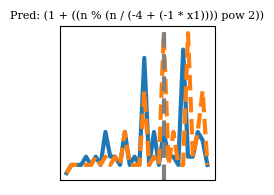

1 A000002  1, 2, 2, 1, 1, 2, 1, 2, 2, 1 ((2 add (-1 mul ((n mod -9) pow 2))) mod 3)


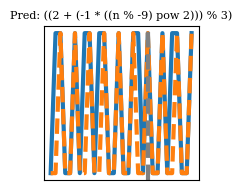

2 A000003  1, 1, 1, 1, 2, 2, 1, 2, 2, 2 ((-1 mul (n idiv -9)) add (n mod (1 add (n idiv 7))))


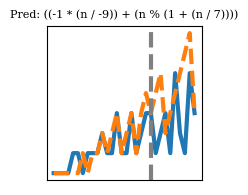

3 A000005  1, 2, 2, 3, 2, 4, 2, 4, 3, 4 (2 add ((n idiv x_0_1) mod (n idiv x_0_1)))


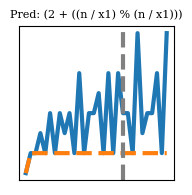

4 A000006  1, 1, 2, 2, 3, 3, 4, 4, 4, 5 ((6 mul n) idiv (7 add x_0_1))


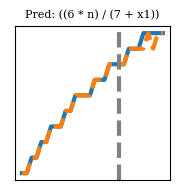

5 A000008  1, 1, 2, 2, 3, 4, 5, 6, 7, 8 ((-1 mul ((n pow 2) idiv -12)) add ((n mod 2) idiv x_0_1))


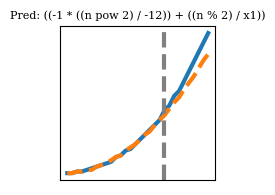

6 A000009  1, 1, 1, 2, 2, 3, 4, 5, 6, 8 (x_0_1 add (-1 mul ((5 add ((-1 mul n) add (-1 mul x_0_1))) idiv 9)))


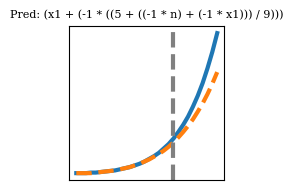

7 A000010  1, 1, 2, 2, 4, 2, 6, 4, 6, 4 (n add ((-1 mul x_0_1) add ((-16 add (n pow 2)) mod x_0_1)))


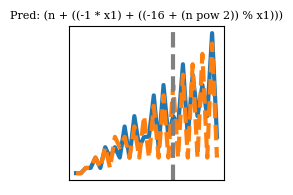

8 A000011  1, 1, 2, 2, 4, 4, 8, 9, 18, 23 (x_0_2 add ((-1 mul ((n mul x_0_2) idiv -9)) add (x_0_1 idiv 5)))


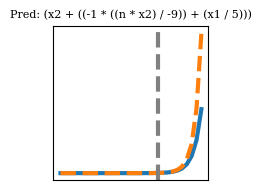

9 A000014  0, 1, 1, 0, 1, 1, 2, 2, 4, 5 ((n mul (x_0_2 add (x_0_3 add x_0_4))) idiv 9)


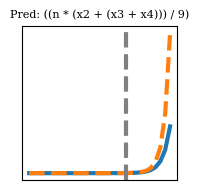

10 A000019  1, 1, 2, 2, 5, 4, 7, 7, 11, 9 (n add ((-1 mul ((n mod -8) mod n)) add (n mod x_0_3)))


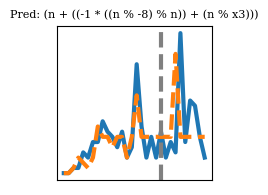

11 A000025  1, 1, -2, 3, -3, 3, -5, 7, -6, 6 ((-1 mul x_0_1) add ((-1 mul ((n pow 2) mod 8)) add ((-1 mul (x_0_2 idiv -4)) add sign(n))))


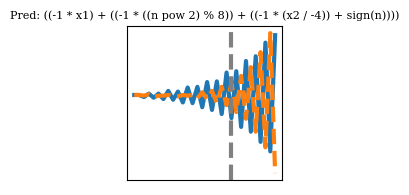

12 A000026  1, 2, 3, 4, 5, 6, 7, 6, 6, 10 (n add (-1 mul step((-6 add (n add (-1 mul ((64 mod n) pow 2)))))))


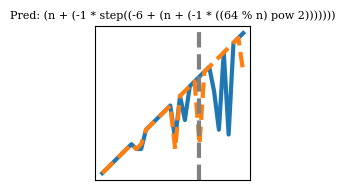

13 A000028  2, 3, 4, 5, 7, 9, 11, 13, 16, 17 (n add (((n idiv 6) pow 2) add (-1 mul (x_0_1 idiv -3))))


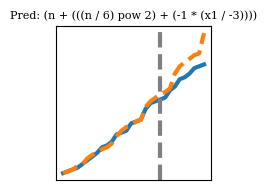

14 A000030  0, 1, 2, 3, 4, 5, 6, 7, 8, 9 (sign((-11 add n)) mod n)


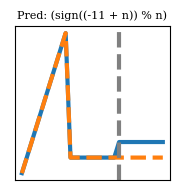

17 A000037  2, 3, 5, 6, 7, 8, 10, 11, 12, 13 (n add (-1 mul (n idiv ((8 add n) idiv -6))))


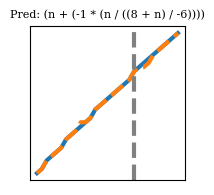

18 A000040  2, 3, 5, 7, 11, 13, 17, 19, 23, 29 (1 add (x_0_1 add (x_0_1 mod (n add (x_0_1 idiv -5)))))


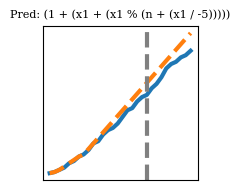

19 A000041  1, 1, 2, 3, 5, 7, 11, 15, 22, 30 ((n add (5 mul x_0_2)) idiv 3)


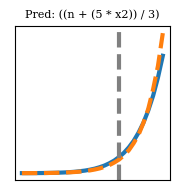

20 A000043  2, 3, 5, 7, 13, 17, 19, 31, 61, 89 (x_0_1 add (2 mul (x_0_1 idiv (n add (-1 mul (1 mod n))))))


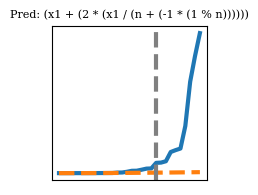

22 A000048  1, 1, 1, 1, 2, 3, 5, 9, 16, 28 ((9 mul x_0_1) idiv 5)


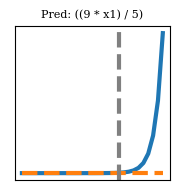

23 A000069  1, 2, 4, 7, 8, 11, 13, 14, 16, 19 (-1 add ((2 mul n) add (((n pow 2) idiv -9) mod -2)))


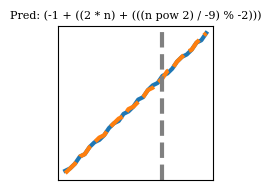

24 A000070  1, 2, 4, 7, 12, 19, 30, 45, 67, 97 (x_0_1 add (-1 mul (((n pow 2) add (4 mul x_0_2)) idiv -10)))


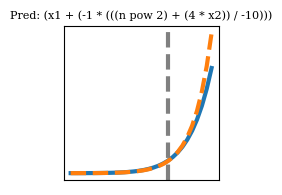

27 A000078  0, 0, 0, 1, 1, 2, 4, 8, 15, 29 ((2 mul x_0_1) add ((n add (-1 mul x_0_1)) idiv 6))


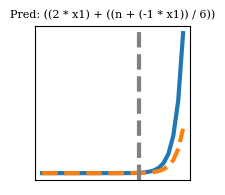

28 A000082  1, 6, 12, 24, 30, 72, 56, 96, 108, 180 (n mul (n add abs((n add (-1 mul (x_0_1 mod (n add (-1 mul (n idiv -2)))))))))


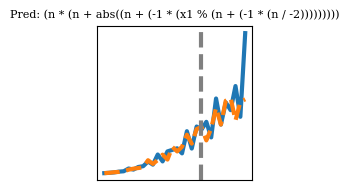

29 A000086  1, 0, 1, 0, 0, 0, 2, 0, 0, 0 step((2 idiv (n mod (6 add x_0_1))))


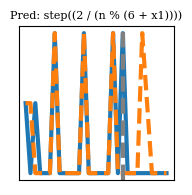

30 A000089  1, 1, 0, 0, 2, 0, 0, 0, 0, 2 ((n mul (n mod 4)) mod (4 add (-1 mul x_0_1)))


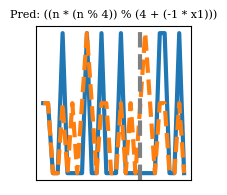

32 A000118  1, 8, 24, 32, 24, 48, 96, 64, 24, 104 ((8 mul n) add ((8 mul (x_0_1 mod n)) add (8 mul (x_0_1 mod (x_0_1 idiv -6)))))


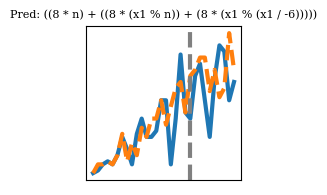

33 A000119  1, 1, 1, 2, 1, 2, 2, 1, 3, 2 (n idiv ((2 mul x_0_4) add sign(n)))


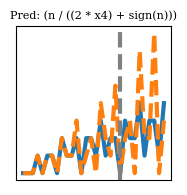

34 A000120  0, 1, 1, 2, 1, 2, 2, 3, 1, 2 ((4 add n) idiv (x_0_1 add ((-1 mul (n mod -8)) add sign(n))))


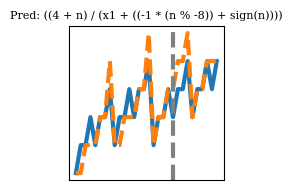

35 A000122  1, 2, 0, 0, 2, 0, 0, 0, 0, 2 (1 add sign(((-10 mod n) mod (-7 add (-1 mul x_0_1)))))


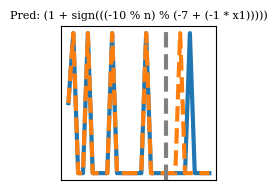

36 A000123  1, 2, 4, 6, 10, 14, 20, 26, 36, 46 (x_0_1 add (-2 mul ((n pow 2) idiv -24)))


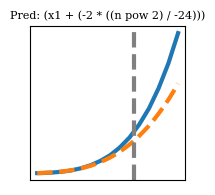

KeyboardInterrupt: 

In [7]:
from oeis import load_oeis
lines, ids = load_oeis(length=30, path="/private/home/sdascoli/recur/OEIS_nice.txt")

def is_monotonic(seq):
    seq = np.array(seq)
    diff = seq[1:]-seq[:-1]
    if all(diff>=0) or all(diff<=0): return True
    else: return False

max_preds = 10
n_correct = 0
plot = True

for i, seq in enumerate(lines):
    #if i==100: break
    #if is_monotonic(seq): continue
    input_seq = seq[:-max_preds]
    _, preds, _, pred_seqs, scores, mses = predict(env, modules, seq=input_seq, pred_len=max_preds)
    pred, pred_seq = preds[0], pred_seqs[0]
    if seq == pred_seq: continue
    n_correct += 1
    print(i, ids[i], ', '.join(str(x) for x in input_seq[:10]), pred)
    #print(seq[-max_preds:], pred_seq[-max_preds:])
    pred = readable_infix(pred)
    
    if plot:
        plt.figure(figsize=(2,2))
        plt.plot(seq)
        plt.plot(pred_seq, ls='--')
        plt.axvline(x=len(input_seq), ls='--', color='grey')
        plt.title(f'Pred: {pred}', fontsize=8)
        plt.xticks([])
        plt.yticks([])
        plt.show()

In [15]:
from oeis import read_url
len(read_url('https://oeis.org/A004045').find('

15993

In [14]:
"abseornaiznr"[9:]

'znr'

# Attention maps

In [ ]:
run = selected_runs[1]
env, modules, trainer, evaluator = load_run(run)
args = run['args']
    
tree, pred_tree, series, preds, score = plot_attention(args, env, modules)

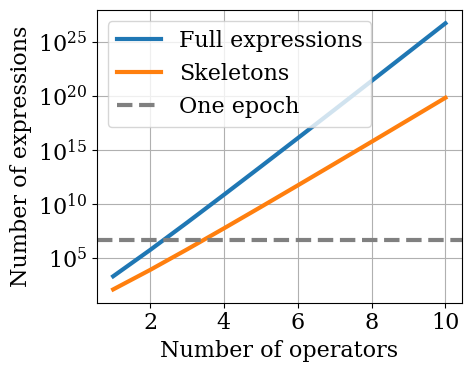

+03 & +05 & +08 & +10 & +13 & +16 & +18 & +21 & +24 & +26
+03 & +05 & +08 & +10 & +13 & +16 & +18 & +21 & +23 & +26


In [65]:
def num_trees(L, p1, p2, n):
    if n==0: return L
    elif n==1: return p2*(L*L+1)/2 + p1*L
    else: return (1/(n+1)) * ((p1+2*L*p2)*(2*n-1)*num_trees(L, p1, p2, n-1) - p1*(n-2)*num_trees(L, p1, p2, n-2))
    #else: return ((p1 + 2*L*p2)*(2*n-1)*num_trees(p1, p2, L, n-1) − p1*(n−2)*num_trees(p1, p2, L, n-2)) / (n+1)
num_trees(1, 0, 1, 5)

num_int = []
num_float = []
num_int_skeleton = []
num_float_skeleton = []
nops = range(1,11)
for nop in nops:
    num_int_skeleton.append(num_trees(6, 4, 5, nop))
    num_float_skeleton.append(num_trees(6, 12, 4, nop))
    num_int.append(num_trees(27, 4, 5, nop))
    num_float.append(num_trees(31, 12, 4, nop))
    
plt.figure(figsize=(5,4))
plt.semilogy(nops, num_int, label='Full expressions')
#plt.semilogy(nops, num_float)
plt.semilogy(nops, num_int_skeleton, label='Skeletons')
#plt.semilogy(nops, num_float_skeleton)
plt.axhline(y=3e5*16, color='grey',ls='--', label='One epoch')
plt.xlabel('Number of operators')
plt.ylabel('Number of expressions')
plt.legend()
plt.tight_layout()
plt.savefig(savedir+'num_expressions.pdf')
plt.show()
print(' & '.join(['{:e}'.format(_).split('e')[-1] for _ in num_int]))
print(' & '.join(['{:e}'.format(_).split('e')[-1] for _ in num_float]))